# Team 12: Nick Morgan, Antolín Moral Caballero, and Yejin Eun

<a id='top'></a>

# Table of Contents
* Problem statement and motivation
* <a href='#data'>Introduction and description of data</a>
    * A revised project workflow based on the insights from EDA
    * <a href='#wrangling'>Data wrangling prior to EDA</a>
    * <a href='#eda'>Exploratory Data Analysis</a>
* <a href='#review'>Literature review / related work</a>
* <a href='#modeling'>Modeling approach and project trajectory</a>
    * <a href='#baseline'>The baseline model</a>
    * <a href='#memory'>Memory-Based Collaborative Filtering</a>
    * <a href='#modelcf'>Model-Based Collaborative Filtering</a>
* <a href='#results'>Results</a>
* <a href='#conclusion'>Conclusions and Future Work</a>

Note: We have hidden most of the code in the notebook and displayed important cells for better readability. 

# Problem statement and motivation

Using user review data from Yelp, our aim was to develop a recommendation system to provide a new restaurant suggestion that a user might like. The project was motivated by the fact that recommendation problems are ubiquitious, including the infamous Netflix challenge and "similar items you might like" suggestions from Amazon. Given the diverse application of this problem, we wanted to learn how to develop and implement such system using machine learning. Below, we graphically illustrate our project goal. 

![alt text](images/projectgoal.png "project goal")

<a id='data'></a>
[back to top](#top)

# Introduction and description of data

![alt text](images/datasetoverview.png "data overview")
Image credit: Yelp

The Yelp data is vast and rich: it contains millions of reviews of different business types (e.g. restaurants and dry cleaners), and each business type has different set of attributes associated with them. Each review at minimum consists of review text and review star rating. Because of its size and richness, it presented an initial challenge for us to decide what data to include in our modeling and what features should be engineered. In addition, not every user has made several reviews or reviews with different ratings, so we needed to figure out what datasets to use for training vs. testing. To this end, we performed EDA on the data, specifically to look at relevant business attributes, user attributes, and reviews. We reasoned that these are the core information needed to link users and businesses with their preferences (hence, we disregarded data such as checkin, photos, and tip). 

## A revised project workflow based on the insights from EDA
We will use the cleaned datasets to accomplish three major goals:
1. Create a baseline estimate of a rating. This simple model will be created by recording the biases of each user and item to make a baseline estimate of a given user-item combination.
2. Create a regularized regression to improve the accuracy of our baseline model.
3. Use a Neighborhood model based on a item-to-item approach as a method of collaborative filtering to improve our model further. Our initial Neighborhood model will not include features of the restaurant, but rather, similarities between restaurants based on the users that have reviewed it.


<a id='wrangling'></a>
[back to top](#top)

## Data wrangling prior to EDA

### Converting JSON files to CSV
We downloaded a 5.6 GB TAR file from Yelp. This TAR file contained second TAR file that we extracted to get a series of JSON files: business, checkin, photos, review, tip, and user. Pandas has a read_json function, but it returned a Trailing Data Error when used on these specific files. As a result, we created a Python script that converts these JSON files into CSV files. 

In [1]:
import time
import json
import pandas as pd
import numpy as np
import re
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def json_to_csv(directory, fileNames, createSample=False):
    """
    json_to_csv: loops through specified JSON files and converts them to csv files.
                 option to also create a sample csv, which uses np.random.seed 9001 to create a sample dataset with 10% of the observations
    
                 pandas has a read_json function, but returns a 'Trailing data error' when working with these specific files
                 
                 
    Inputs: -directory of JSON files
            -list of JSON filenames
            -createSample flag
    """
    
    start = time.time()

    jsonData = []

    for fileName in fileNames:
        with open(directory + fileName,  encoding="utf8") as file:
            print('{0} opened'.format(fileName))
            for line in file:
                #I use an rstrip here because some of the files have trailing blank spaces
                jsonData.append(json.loads(line.rstrip()))
        
        df = pd.DataFrame.from_dict(jsonData)
        
        csvFileName = fileName[:len(fileName)-5] + '.csv'
        
        df.to_csv(directory + csvFileName)
        print('{0} created'.format(csvFileName))
        
        
        if createSample:
            np.random.seed(9001)
            msk = np.random.rand(len(df)) <= 0.1
            sample = df[msk]
            
            csvSampleFileName = fileName[:len(fileName)-5] + '_sample.csv'
            
            sample.to_csv(directory + csvSampleFileName)
            print('{0} created'.format(csvSampleFileName))
        
    print('This function took {} minutes to run'.format((time.time()-start)/60))

In [3]:
fileNameList = ['user.json',
                'business.json',
                'review.json']

json_to_csv('data/', fileNameList, createSample=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/user.json'

### Keeping only "restaurant" business data and other associated data on users and reviews
We reduced the business dataset to businesses that had “Restaurant” or “Food” in the category (restaurants). We then removed observations that had other “non-restaurant” categories, such as “Grocery”, “Auto Glass Services”, “Business Consulting”, etc. After reducing the business dataset, we reduced our review dataset in two ways:
* Only including reviews for businesses that existed in the reduced business (restaurant) dataset 
* Only including reviews for users that have at least 2 reviews (A single rating does not help determine similarities between restaurants)

In summary, we began with 156,639 observations. 15,502 of these observations contained "Food" or "Restaurants". After removing observations with irrelevant categories, we are left with 14,032 total observations.

In [4]:
def find_ftres_with_nan(df):
    all_nan = df.columns[df.isnull().all()].tolist()
    some_nan = df.columns[df.isnull().any()].tolist()
    print("All NaN Features: ", len(all_nan), all_nan, "Some NaN Features: ", len(some_nan), some_nan)
    return all_nan, some_nan

In [5]:
business = pd.read_pickle("final_business_CA.gzip")
all_nan, some_nan = find_ftres_with_nan(business)

All NaN Features:  0 [] Some NaN Features:  2 ['attributes', 'hours']


Number of businesses that have both "food" and "restaurant" in their category:

In [7]:
# create a mask for restaurants
mask_restaurants = business['categories'].str.contains('Restaurants')

# create a mask for food
mask_food = business['categories'].str.contains('Food')

# apply both masks
restaurants_and_food = business[mask_restaurants & mask_food]

# number of businesses that have food and restaurant in their category
restaurants_and_food['categories'].count()

474

Even after taking buisnesses that have both food and restaurant in their categories, there are still irrelevant business categories in the data. 

In [8]:
# an example row
restaurants_and_food.head(1)['categories'].values

array(['Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries'],
      dtype=object)

Thus, we manually identified additional categories that needed to be excluded specifically. 

In [9]:
categoryDF = restaurants_and_food['categories'].apply(lambda x: x[1:-1].split(',')).apply(pd.Series)
uniqueCategories = pd.DataFrame(categoryDF.stack().str.strip().unique())

In [10]:
categoriesToRemove = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services',
                      'Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical',
                      'Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing',
                      'Oil Change Stations', 'Auto Repair','Body Shops','Car Window Tinting','Car Wash',
                      'Gluten-Free','Fitness & Instruction','Nurseries & Gardening','Wedding Planning',
                      'Embroidery & Crochet','Dance Schools','Performing Arts',
                      'Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services',
                      'Electronics','Plumbing','Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores',
                      'Pet Groomers','Vape Shops','Head Shops',
                      'Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals',
                      'Tattoo','Funeral Services & Cemeteries','Sporting Goods','Dog Walkers',
                      'Pet Boarding/Pet Sitting','Scavenger Hunts','Contractors','Trainers', 
                      'Customized Merchandise', 'Dry Cleaning & Laundry', 'Art Galleries'
                      'Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 
                      'Business Consulting', 'Lawyers', 'Pet Adoption', 'Escape Games', 
                      'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 
                      'Real Estate Services', 'Home Inspectors']

In [12]:
restaurants_df = restaurants_and_food[~restaurants_and_food['categories'].str.contains('|'.join(categoriesToRemove))]

In [13]:
restaurants_df.to_pickle('restaurants.gzip')
restaurants_df = pd.read_pickle('restaurants.gzip')
all_nan, some_nan = find_ftres_with_nan(restaurants_df)

All NaN Features:  0 [] Some NaN Features:  2 ['attributes', 'hours']


In [14]:
restaurants_df.iloc[1]['attributes']

{'OutdoorSeating': 'True',
 'RestaurantsAttire': "'casual'",
 'RestaurantsReservations': 'False',
 'BusinessAcceptsCreditCards': 'True',
 'NoiseLevel': "u'average'",
 'RestaurantsPriceRange2': '2',
 'RestaurantsGoodForGroups': 'False',
 'WiFi': "u'no'",
 'Alcohol': "'beer_and_wine'",
 'RestaurantsTakeOut': 'True',
 'BikeParking': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': True, 'lot': False, 'valet': False}",
 'HasTV': 'False',
 'ByAppointmentOnly': 'False',
 'GoodForKids': 'True',
 'Caters': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': True}",
 'RestaurantsDelivery': 'True',
 'HappyHour': 'False',
 'Music': "{u'dj': False, u'live': False, u'jukebox': False, u'video': False, u'background_music': False, u'karaoke': False, u'no_music': False}",
 'GoodForMeal': "{u'breakfast': False, u'brunch': None, u'lunch': True, u'dinner':

### Expanding business attributes & categories
After cleaning the business dataset, we expanded the attributes into boolean features. The attributes were a collection of a string of a dictionary. We evaluated this string as a dictionary and applied pd.Series across the result, which expanded this dictionary into multiple Boolean columns, as well as a few more dictionary columns. All remaining dictionary columns were manipulated in the same manner, leaving us ~70 Boolean columns. The business dataset also had a variable, categories, that was a string of a list. We expanded this list into separate columns for each category. Lastly, we then reduced our user dataset by filtering to users that existed in the reduced review dataset. The following functions were used for this process. 

In [15]:
#create_attributes

#takes a dataframe as an input, as well as a list of columns that are dictionaries
#takes each column that is a dictionary, and expands it into a series of dummy columns
def map_eval(x):
    return eval(str(x))

def create_attributes(df, dictList):
    
    for dictionaryColumn in dictList:
        
        #the attributes column is a string of dictionaries, so one extra step is taken to convert
        if dictionaryColumn == 'attributes':
            try:
                expandedColumns = df[dictionaryColumn].map(map_eval).apply(pd.Series)
            except:
                print(df[dictionaryColumn])
        else:
            expandedColumns = df[dictionaryColumn].apply(pd.Series)
        
        df = pd.concat([df.drop(dictionaryColumn,axis=1), 
                   expandedColumns]
                  ,axis=1)
        
        #df.fillna(value='{}',inplace=True)
        
    return df

In [16]:
def expand_categories(df, cat_var, key):
    all_cats = df[cat_var].str.cat(sep=', ')
    all_cats = all_cats.replace('[', '')
    all_cats = all_cats.replace(']', '')
    all_cats = all_cats.replace("\'","")
    all_cats = all_cats.replace('"','')
    all_cats_list = all_cats.split(', ')
    unique_cats = list(set(all_cats_list))
    unique_cats.remove('Restaurants')
    unique_cats.remove('Food')
    df_cats = pd.DataFrame(index=df[key], columns=unique_cats, data=False)
    df_out = df.merge(df_cats, how='left', left_on=key, right_index=True)
    for cat in unique_cats:
        df_out[cat] = df_out[cat_var].str.contains(cat)
    return df_out  

In [17]:
dictList = ['attributes', 'Ambience', 'BestNights', 'BusinessParking','Music','GoodForMeal']
expanded = create_attributes(restaurants_df[['business_id','attributes']], dictList)

dropColumns = expanded.columns.get_loc(0)
keepColumns = list(compress(expanded.columns, ~dropColumns))
expanded = expanded[keepColumns]

In [18]:
print(keepColumns)

['business_id', 'RestaurantsTakeOut', 'NoiseLevel', 'Caters', 'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'RestaurantsTableService', 'GoodForKids', 'RestaurantsPriceRange2', 'WheelchairAccessible', 'OutdoorSeating', 'RestaurantsDelivery', 'HasTV', 'RestaurantsAttire', 'Alcohol', 'DogsAllowed', 'RestaurantsGoodForGroups', 'HappyHour', 'BikeParking', 'WiFi', 'ByAppointmentOnly', 'CoatCheck', 'BusinessAcceptsBitcoin', 'Corkage', 'BYOB', 'BYOBCorkage', 'DriveThru', 'GoodForDancing', 'Smoking']


In [19]:
expanded.head(1)

,business_id,RestaurantsTakeOut,NoiseLevel,Caters,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsTableService,GoodForKids,RestaurantsPriceRange2,WheelchairAccessible,...,WiFi,ByAppointmentOnly,CoatCheck,BusinessAcceptsBitcoin,Corkage,BYOB,BYOBCorkage,DriveThru,GoodForDancing,Smoking
85,IDtLPgUrqorrpqSLdfMhZQ,True,u'average',True,False,True,False,True,2,True,...,u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before expansion:

In [20]:
restaurants_df.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
85,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': '...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."


After expansion:

In [29]:
expanded.head(1)

,business_id,RestaurantsTakeOut,NoiseLevel,Caters,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsTableService,GoodForKids,RestaurantsPriceRange2,WheelchairAccessible,...,WiFi,ByAppointmentOnly,CoatCheck,BusinessAcceptsBitcoin,Corkage,BYOB,BYOBCorkage,DriveThru,GoodForDancing,Smoking
85,IDtLPgUrqorrpqSLdfMhZQ,True,u'average',True,False,True,False,True,2,True,...,u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
## Join expanded with restaurants_df
restaurants_df = restaurants_df.merge(expanded, how='left', left_on='business_id', right_on='business_id')
restaurants_df.drop('attributes', axis=1, inplace=True)

In [22]:
restaurants_df.head(1)['categories']

0    Food, Restaurants, Salad, Coffee & Tea, Breakf...
Name: categories, dtype: object

In [23]:
restaurants_df = expand_categories(restaurants_df, 'categories', 'business_id')
restaurants_df.drop('categories', axis=1, inplace=True)
# Variables that won't be used
# rest_vars_to_drop = ['address', 'hours', 'latitude', 'longitude', 'name']
rest_vars_to_drop = ['address', 'hours', 'latitude', 'longitude']
restaurants_final = restaurants_df.drop(rest_vars_to_drop, axis=1)
restaurants_final.to_pickle('restaurants_final.gzip')

/var/folders/rd/1wqnsccd7yv7906kcv9tdzbc0000gn/T/ipykernel_78183/1014198108.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_out[cat] = df_out[cat_var].str.contains(cat)


After cleaning up the business data, we kept relevant review and user data only. 

In [24]:
def reduce_review(df, business_list):
    
    #drop columns where business_id or user_id is null
    df.dropna(subset=['business_id','user_id'], how='any',inplace=True)
    
    #restrict to businesses that are restaurants
    df = df[df['business_id'].isin(business_list)]
    
    #only keep user_id's with more than one review
    df = df[df.groupby('user_id').user_id.transform(len) > 1]
    
    #verify this worked by taking the minimum amount of user_id counts
    print('The minimum amount of reviews per user is {}'
          .format(np.min(df.groupby('user_id')['business_id'].count())))
    return df

In [25]:
review = pd.read_pickle('final_review_CA.gzip')
restaurant_reviews = reduce_review(review, restaurants_final['business_id']) #create dataframe
_, _ = find_ftres_with_nan(restaurant_reviews) #report if there are null values

restaurant_reviews['review_date'] = pd.to_datetime(restaurant_reviews['date'])
restaurant_reviews['review_year'] = restaurant_reviews['review_date'].dt.year
restaurant_reviews['review_month'] = restaurant_reviews['review_date'].dt.month
#restaurant_reviews['review_weekday'] = restaurant_reviews['review_date'].dt.weekday

rename_cols = {'cool': 'review_cool','funny':'review_funny','stars':'review_stars','useful':'review_useful'}
restaurant_reviews.rename(columns=rename_cols, inplace=True)
review_cols_to_drop = ['text', 'review_date', 'date']
restaurant_reviews.drop(review_cols_to_drop, axis=1, inplace=True)

The minimum amount of reviews per user is 2
All NaN Features:  0 [] Some NaN Features:  0 []


In [26]:
restaurant_reviews.head()

,review_id,user_id,business_id,review_stars,review_useful,review_funny,review_cool,review_year,review_month
31,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5,0,0,0,2017,1
73,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1,1,0,0,2011,8
79,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,0,0,0,2017,8
154,bi6GaeWDGceGv62lXTIKQA,RgtbLaiU22zqaCk20HgbiQ,bjhCtlYHrkgA5Ku8l-rB3g,1,1,0,0,2015,1
169,LO2C_mywzQy5BvdEeONR1A,jvURGq9nyZkTF1KuSaZC_g,CYwC5OjwCN6ib_AQDxi3Ow,5,0,0,0,2016,8


In [27]:
restaurant_reviews.to_pickle('restaurant_reviews_final.gzip')

In [28]:
users_w_reviews.head(5)

NameError: name 'users_w_reviews' is not defined

In [29]:
users_df = pd.read_pickle('final_data_user_yelp.gzip')
users_w_reviews = users_df[users_df['user_id'].isin(restaurant_reviews['user_id'])].copy()

list_user_vars = ['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 
                  'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 
                  'compliment_photos', 'compliment_plain', 'compliment_profile', 
                  'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 
                  'name', 'review_count', 'useful']
vars_to_rename_users = dict(zip(list_user_vars, ['user_' + var for var in list_user_vars]))
users_w_reviews = users_w_reviews.rename(columns=vars_to_rename_users)

#users_w_reviews['yelping_since'] = pd.to_datetime(users_w_reviews['yelping_since'])
#users_w_reviews['yelping_since'] = users_w_reviews['yelping_since'].dt.year

#users_w_reviews['user_elite_flag'] = users_w_reviews['user_useful'].apply(len) != 2
#users_w_reviews['user_friends_flag'] = users_w_reviews['user_fans'].apply(len) != 2

#users_cols_to_drop = ['user_elite', 'user_friends', 'user_name']
#users_w_reviews.drop(users_cols_to_drop, axis=1, inplace=True)

users_w_reviews.to_pickle('user_final.gzip')

In [30]:
users_w_reviews.head(1)

,user_id,user_review_count,user_useful,user_fans
29,4ZaqBJqt7laPPs8xfWvr6A,801,1944,75


Then we finally merged all cleaned DFs. 

In [31]:
recommendations_p1 = restaurant_reviews.merge(restaurants_final, how='left', on='business_id')
#recommendations_p1['user_id'] = recommendations_p1['user_id_x']
#recommendations_p1.drop(axis=1, inplace=True, labels=['user_id_x'])
recommendations = recommendations_p1.merge(users_w_reviews, how='left', on='user_id')

In [32]:
recommendations.to_pickle('recommendations.gzip')

np.random.seed(9001)
msk = np.random.rand(len(recommendations)) <= 0.9
sample = recommendations[msk]
sample = sample[sample.groupby('user_id').user_id.transform(len) > 1]
recommendations.to_pickle('sample.gzip') #temporary to speed up processes

In [33]:
recommendations.head()

,review_id,user_id,business_id,review_stars,review_useful,review_funny,review_cool,review_year,review_month,name,...,Donuts,Steakhouses,American (New),Coffeeshops,Wine Tours,Hotels & Travel,Wine Tasting Classes,user_review_count,user_useful,user_fans
0,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5,0,0,0,2017,1,The Original Habit Burger Grill,...,False,False,False,False,False,False,False,922,1687,51
1,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1,1,0,0,2011,8,Jack in the Box,...,False,False,False,False,False,False,False,37,16,0
2,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,0,0,0,2017,8,PizzaMan Dan's,...,False,False,False,False,False,False,False,18,4,0
3,bi6GaeWDGceGv62lXTIKQA,RgtbLaiU22zqaCk20HgbiQ,bjhCtlYHrkgA5Ku8l-rB3g,1,1,0,0,2015,1,Our Daily Bread,...,False,False,False,False,False,False,False,122,156,5
4,LO2C_mywzQy5BvdEeONR1A,jvURGq9nyZkTF1KuSaZC_g,CYwC5OjwCN6ib_AQDxi3Ow,5,0,0,0,2016,8,In-N-Out Burger,...,False,False,False,False,False,False,False,26,7,0


<a id='eda'></a>
[back to top](#top)

## Exploratory Data Analysis

### Most users have only a few number of reviews. 
Most users have only 1, 2 or 3 reviews (90% of users have less than 10 reviews) and the average stars per user (including all type of business, not restricted to restaurants) is 3.75. This indicates that a final matrix with users and businesses will be a sparse matrix. It may be difficult to give recommendations to users that don’t review many restaurants, especially if those restaurants don’t have many reviews. Further, there are 2,373 users that rate everything as 1, which will make recommendations difficult as we do not have data of anything they like so we won’t make recommendations for those users.


In [34]:
reviews = pd.read_pickle('restaurant_reviews_final.gzip')

In [35]:
def num_reviews_per_var(df, group_var, count_var, max_count, title_axis_x, title_axis_y):
    num_review_per_var = df.groupby(group_var, as_index=False).count()[[group_var, count_var]]
    num_review_per_var.columns.values[1] = 'num_reviews_per_var'
    reviews_per_var = num_review_per_var.groupby('num_reviews_per_var', as_index=False).count()
    reviews_per_var.columns.values[1] = 'num_' + group_var
    more_than_x = reviews_per_var[reviews_per_var['num_reviews_per_var']>=max_count].sum().to_frame().T
    more_than_x['num_reviews_per_var'] = max_count
    reviews_per_var = pd.concat([reviews_per_var[reviews_per_var['num_reviews_per_var']<max_count],
                                 more_than_x]).reset_index(drop=True)
    total_var = reviews_per_var['num_' + group_var].sum()
    reviews_per_var['num_' + group_var] = 100*reviews_per_var['num_' + group_var]/total_var
    ax = reviews_per_var.plot(x='num_reviews_per_var',y='num_' + group_var, kind='bar')    
    ax.set_ylabel(title_axis_y)
    ax.set_xlabel(title_axis_x)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.0f%%'))

In [36]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
sns.set_context('paper', rc={"font.size":20,"axes.titlesize":20, "axes.labelsize":20,
                             "xtick.labelsize":20, "ytick.labelsize":20})

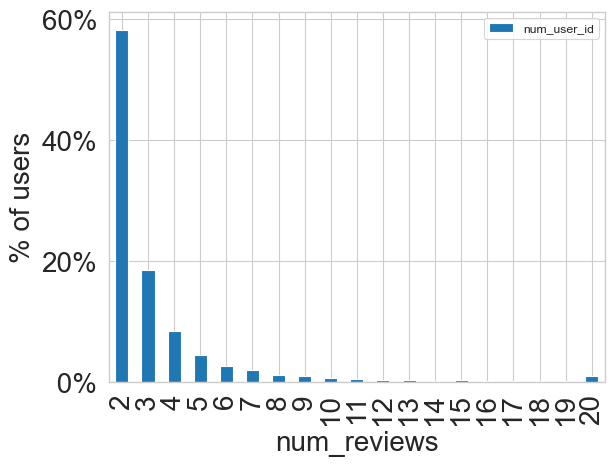

In [37]:
num_reviews_per_var(reviews, 'user_id', 'review_id', 20, 'num_reviews', '% of users')

### User bias: some users tend to give higher ratings than others.
The histogram also shows differences in the average stars per user showing that some users tend to give higher ratings than others. These biases between users will be captured by our baseline model. 

In [38]:
users = pd.read_pickle('user_final.gzip')

user_ftres = [user_ftre for user_ftre in users.columns.tolist() if 'user_' in user_ftre]
y_user = 'user_average_stars'
user_compl_ftres = [ftre for ftre in user_ftres if 'user_compliment' in ftre]
user_count_ftres = ['user_cool', 'user_fans', 'user_funny', 'user_review_count', 'user_useful']
user_cat_ftres = ['user_elite_flag', 'user_friends_flag', 'yelping_since']

KeyError: 'user_average_stars'

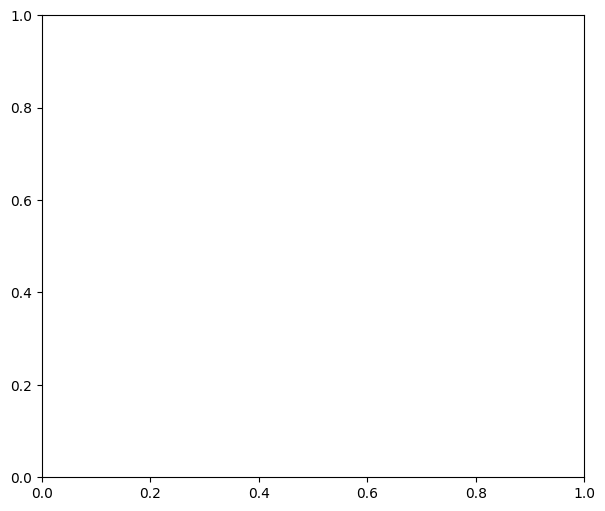

In [101]:
fig, ax = plt.subplots(1,1, figsize=(7, 6))
users[y_user].plot(kind='hist', ax=ax)
ax.set_xlabel('Users Average Stars')
plt.show()

### Most businesses have more than 3 reviews.
Looking at business, the distribution of number of reviews per business is less ‘right-skewed’ and we have more restaurants with more than 3 reviews. 

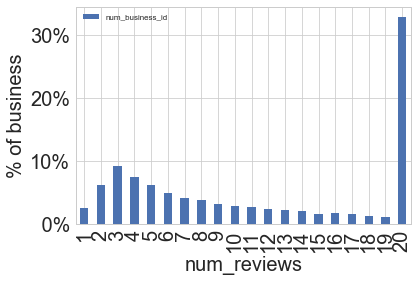

In [22]:
num_reviews_per_var(reviews, 'business_id', 'review_id', 20, 'num_reviews', '% of business')

### Reducing the number of business categories
After expanding the business categories, we ended up with a dataframe of ~460 columns where each column was a distinct category. This number is too large, and we had to select categories that were more relevant to the goal of making recommendations to users. To find out which categories are most prominent and which are relevant for restaurant recommendation, we first got rid of the categories that only occur a few times in the dataset (the cutoff used was 11). These tended to be the ones not relevant to restaurants. Looking at the top 10 and bottom 10 categories in terms of number of occurrences, we found that the top 10 are mostly fast food or quick food places, and the bottom 10 are mostly ethnic food places. This gave us the idea that if two users like some of these rarely occurring restaurant categories, perhaps we could give them a greater weight when predicting/recommending the next restaurant. 

In [39]:
from sklearn.decomposition import PCA
sns.set_context('poster')
sns.set_style('white')
pd.set_option('display.max_columns', None)  

business_df = pd.read_pickle('restaurants_final.gzip')

In [40]:
busi_categories = ['Playgrounds',
       'Coffee & Tea', 'African', 'Jazz & Blues', 'Bagels', 'Coffeeshops',
       'Swimming Pools', 'Diners', 'Flea Markets', 'Fast Food', 'German',
       'Organic Stores', 'Dominican', 'Hot Dogs', 'Hotels & Travel',
       'Tea Rooms', 'Cheese Tasting Classes', 'Tasting Classes',
       'Gay Bars', 'Cupcakes', 'Art Classes', 'Beer Bar',
       'Coffee Roasteries', 'Cafeteria', 'Karaoke', 'Street Vendors',
       'Salad', 'Tapas/Small Plates', 'Poke', 'American (Traditional)',
       'Chocolatiers & Shops', 'Casinos', 'Notaries',
       'Country Dance Halls', 'Public Markets', 'Financial Services',
       'Drive-Thru Bars', 'Armenian', 'Popcorn Shops',
       'Adult Entertainment', 'Pasta Shops', 'Bowling', 'South African',
       'Gift Shops', 'Persian/Iranian', 'Golf', 'Beer Hall', 'Kosher',
       'Smokehouse', 'Basque', 'Landmarks & Historical Buildings',
       'Festivals', 'Amusement Parks', 'Eastern European', 'Gastropubs',
       'Do-It-Yourself Food', 'Puerto Rican', 'Fischbroetchen',
       'Creperies', 'New Mexican Cuisine', 'Wraps', 'Specialty Schools',
       'Fruits & Veggies', 'Japanese', 'British', 'Beer Garden',
       'Wineries', 'Arts & Crafts', 'Leisure Centers', 'Beer',
       'Wine & Spirits', 'Sandwiches', 'Fishmonger', 'Irish Pub',
       'Home Services', 'Social Clubs', 'Pop-up Shops', 'Polish',
       'Custom Cakes', 'Canadian (New)', 'Middle Eastern', 'Wine Bars',
       'Bistros', 'Hakka', 'Arcades', 'Halal', 'Trinidadian', 'Swabian',
       'Turkish', 'Food Stands', 'Breakfast & Brunch', 'Hookah Bars',
       'CSA', 'Alsatian', 'Chicken Shop', 'Airports', 'Shopping Centers',
       'Soul Food', 'Meat Shops', 'Dim Sum', 'Pita', 'Tabletop Games',
       'Moroccan', 'Knife Sharpening', 'Cafes', 'Food Trucks', 'Shopping',
       'Acai Bowls', 'Spanish', 'Cheesesteaks', 'Churches', 'Hungarian',
       'Cambodian', 'Hawaiian', 'Australian', 'Delis', 'Szechuan',
       'Music Venues', 'Pub Food', 'Malaysian', 'Special Education',
       'Chicken Wings', 'Juice Bars & Smoothies', 'Bed & Breakfast',
       'Swiss Food', 'Dance Clubs', 'Kids Activities', 'Local Flavor',
       'Flatbread', 'Gun/Rifle Ranges', 'Baden', 'Asian Fusion',
       'Laser Tag', 'Vegetarian', 'Colombian', 'Laotian', 'Olive Oil',
       'Delicatessen', 'Poutineries', 'Teppanyaki', 'Resorts', 'Afghan',
       'Seafood Markets', 'Scottish', 'Shared Office Spaces',
       'Cajun/Creole', 'Champagne Bars', 'Peruvian', 'Speakeasies',
       'Bavarian', 'Food Delivery Services', 'Breweries',
       'Ice Cream & Frozen Yogurt', 'Tapas Bars', 'Tours', 'Curry Sausage',
       'Taiwanese', 'Food Court', 'Vegan', 'Cocktail Bars', 'Brasseries',
       'Desserts', 'Steakhouses', 'Community Service/Non-Profit',
       'Vitamins & Supplements', 'Mountain Biking', 'Sugar Shacks',
       'Lounges', 'French', 'Health Markets', 'Waffles',
       'Shaved Snow', 'Batting Cages', 'Sports Bars', 'Bakeries',
       'Beverage Store', 'Themed Cafes', 'Vietnamese',
       'Arts & Entertainment', 'Antiques', 'Czech', 'Cooking Schools',
       'Austrian', 'Patisserie/Cake Shop', 'Hong Kong Style Cafe', 'Ramen',
       'Sports Clubs', 'Mongolian', 'Shaved Ice', 'Tacos',
       'American (New)', 'Lebanese', 'Flowers & Gifts', 'Chinese',
       'Indian', 'Local Services', 'Ethnic Food', 'Himalayan/Nepalese',
       'Florists', 'Pizza', 'Club Crawl', 'Seafood', 'Argentine',
       'Tex-Mex', 'Brazilian', 'Egyptian', 'Sri Lankan',
       'Wine Tasting Room', 'Donuts', 'Wigs', 'Cuban', 'Active Life',
       'Salvadoran', 'Greek', 'Mulled Wine', 'Kiosk', 'Falafel',
       'Personal Shopping', 'Candy Stores', 'Pakistani', 'International',
       'Beer Gardens', 'Amateur Sports Teams', 'Gelato', 'Mosques', 'Pubs',
       'Comedy Clubs', 'Pool Halls', 'Southern', 'Imported Food',
       'Sushi Bars', 'Cheese Shops', 'Pan Asian', 'Bubble Tea',
       'Banks & Credit Unions', 'Education', 'Indonesian', 'Food Tours',
       'Coffee & Tea Supplies', 'Noodles', 'Fish & Chips', 'Kebab',
       'Milkshake Bars', 'Korean', 'Cabaret', 'Japanese Curry',
       'Farmers Market', 'Public Services & Government', 'Irish',
       'Parent Cafes', 'Latin American', 'Real Estate', 'Insurance',
       'Burgers', 'Wine Tours', 'Arabian', 'Buffets', 'Whiskey Bars',
       'Caribbean', 'Slovakian', 'Tuscan', 'Ukrainian', 'Distilleries',
       'Ethiopian', 'Izakaya', 'Financial Advising', 'Barbeque',
       'Religious Organizations', 'Cantonese', 'Empanadas', 'Hot Pot',
       'Modern European', 'Internet Cafes', 'Kombucha', 'Nightlife',
       'Thai', 'Bangladeshi', 'Bars', 'Venezuelan', 'Dive Bars', 'Fondue',
       'Guest Houses', 'Mediterranean', 'Belgian', 'Portuguese', 'Donairs',
       'Russian', 'Herbs & Spices', 'Mexican', 'Macarons', 'Cinema',
       'Butcher', 'Filipino', 'Pretzels', 'Reunion', 'Live/Raw Food',
       'Mini Golf', 'Scandinavian', 'Burmese', 'Yelp Events',
       'Specialty Food', 'Couriers & Delivery Services', 'Soup',
       'Singaporean', 'Comfort Food', 'Museums', 'Italian']

not_categories = ['Religious Organizations', 'Moroccan', 'Southern', 'Pool Halls', 'Swimming Pools', 'Wraps', 'Tuscan',
                  'Hungarian', 'Drive-Thru Bars', 'Public Services & Government', 'German', 'Cinema', 'Golf',
                  'Community Service/Non-Profit', 'Coffee & Tea Supplies', 'Active Life', 'Czech', 'Kosher',
                  'Social Clubs', 'Landmarks & Historical Buildings', 'Teppanyaki', 'Persian/Iranian',
                  'Delicatessen', 'Cooking Schools', 'Salvadoran', 'Themed Cafes', 'Brasseries', 'Kebab',
                  'Scottish', 'Izakaya', 'Waffles', 'Flowers & Gifts', 'Popcorn Shops', 'Fondue', 'Colombian',
                  'Dance Clubs', 'Pan Asian', 'Afghan', 'Personal Shopping', 'Whiskey Bars', 'Adult Entertainment',
                  'Trinidadian', 'Egyptian', 'Country Dance Halls', 'Lebanese', 'Filipino', 'Cantonese', 'Kids Activities',
                  'Falafel', 'Bed & Breakfast', 'Gift Shops', 'Portuguese', 'Irish', 'Speakeasies', 'CSA', 'Pretzels', 'Public Markets',
                  'Specialty Schools', 'Basque', 'Internet Cafes', 'African', 'Comedy Clubs', 'Bowling', 'Sri Lankan', 'Distilleries',
                  'Amusement Parks', 'Poutineries', 'Bangladeshi', 'Banks & Credit Unions', 'Chocolatiers & Shops', 'Casinos', 'Cuban',
                  'Singaporean', 'Mongolian', 'Cambodian', 'Donairs', 'Airports', 'International', 'Venezuelan', 'Real Estate',
                  'Japanese Curry', 'Couriers & Delivery Services', 'Flea Markets', 'Laotian', 'Dominican', 'Peruvian', 'Irish Pub',
                  'Churches', 'Macarons', 'Pita', 'Parent Cafes', 'Ukrainian', 'Arcades', 'Puerto Rican', 'Armenian', 'Shaved Snow',
                  'Caribbean', 'Custom Cakes', 'Smokehouse', 'Vitamins & Supplements', 'Kiosk', 'Food Tours', 'Shared Office Spaces',
                  'British', 'Malaysian', 'Yelp Events', 'Financial Advising', 'Eastern European', 'Beverage Store', 'Florists', 'Wigs',
                  'Resorts', 'Sports Clubs', 'Burmese', 'Bistros', 'South African', 'Butcher', 'Kombucha', 'Candy Stores', 'Herbs & Spices',
                  'Russian', 'Himalayan/Nepalese', 'Fruits & Veggies', 'Canadian (New)', 'Polish', 'Museums', 'Financial Services', 'Austrian',
                  'Antiques', 'Mini Golf', 'Guest Houses', 'Pub Food', 'Playgrounds', 'Baden', 'Flatbread', 'Arabian', 'Slovakian', 'Reunion', 'Amateur Sports Teams', 'Art Classes', 'Swiss Food', 'Mosques', 'Notaries', 'Special Education', 'Fischbroetchen', 'Alsatian', 'Olive Oil', 'Leisure Centers', 'Bavarian', 'Cheese Tasting Classes', 'Fishmonger', 'Swabian', 'Batting Cages', 'Hakka', 'Mulled Wine', 'Curry Sausage', 'Insurance', 'Mountain Biking', 'Beer Hall', 'Milkshake Bars', 'Cabaret', 'Laser Tag', 'Gun/Rifle Ranges', 'Knife Sharpening', 'Sugar Shacks', 'Beer Garden']
busi_categories = list(set(busi_categories) - set(not_categories))

In [41]:
busi_categories

['Club Crawl',
 'Shopping',
 'Desserts',
 'Ice Cream & Frozen Yogurt',
 'Modern European',
 'Buffets',
 'Argentine',
 'Hookah Bars',
 'Festivals',
 'Tasting Classes',
 'Food Trucks',
 'Jazz & Blues',
 'Lounges',
 'Fast Food',
 'Brazilian',
 'Szechuan',
 'Comfort Food',
 'Sandwiches',
 'Pizza',
 'Tea Rooms',
 'Music Venues',
 'Wineries',
 'Food Delivery Services',
 'French',
 'American (Traditional)',
 'Delis',
 'Tex-Mex',
 'Italian',
 'Local Services',
 'Hong Kong Style Cafe',
 'Creperies',
 'Ethiopian',
 'Cafeteria',
 'Korean',
 'Health Markets',
 'Coffee Roasteries',
 'Chinese',
 'Chicken Wings',
 'Taiwanese',
 'Scandinavian',
 'Cheese Shops',
 'Vietnamese',
 'Cafes',
 'Seafood',
 'Shaved Ice',
 'Gastropubs',
 'Beer',
 'Home Services',
 'Street Vendors',
 'Wine Bars',
 'Belgian',
 'Farmers Market',
 'Bubble Tea',
 'Middle Eastern',
 'Australian',
 'Bagels',
 'Wine & Spirits',
 'Cajun/Creole',
 'Beer Gardens',
 'Pop-up Shops',
 'Japanese',
 'Tours',
 'Tabletop Games',
 'Chicken Shop',

In [42]:
num_busi_cat = business_df[busi_categories].sum()
# only consider those with total counts greater than 11
num_busi_cat = num_busi_cat[num_busi_cat > 11]
num_busi_cat.sort_values(axis=0, ascending=False, inplace=True)
num_busi_cat = num_busi_cat.reset_index()
num_busi_cat.columns = ['category', 'count']

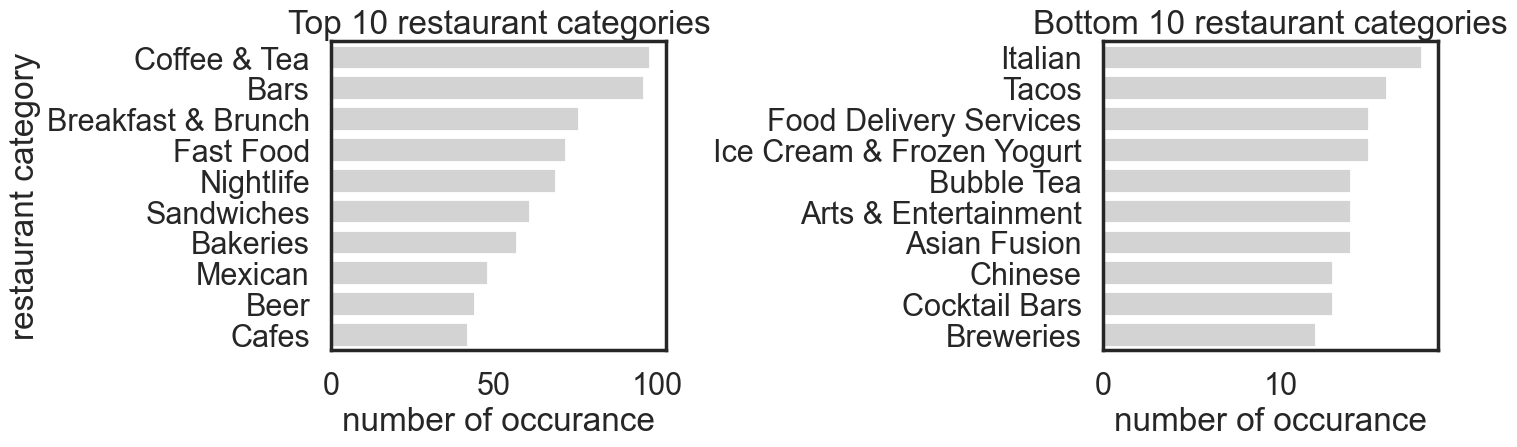

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='count', y='category', data=num_busi_cat.head(10), color='lightgrey', ax=ax[0])
ax[0].set(ylabel='restaurant category')
ax[0].set(xlabel='number of occurance')
ax[0].set(title='Top 10 restaurant categories')
sns.barplot(x='count', y='category', data=num_busi_cat.tail(10), color='lightgrey', ax=ax[1])
ax[1].set(xlabel='number of occurance')
ax[1].set(title='Bottom 10 restaurant categories')
ax[1].set(ylabel='')
plt.tight_layout()
plt.show()

### Restaurant categories can be further reduced to a smaller set of dimensions. 
After getting rid of the categories that only occur a few times in the dataset, we still had ~180 restaurant categories. While this number is smaller than the original we started with (~460), we sought to further reduce the number by performing dimensionality reduction (specifically, PCA). By doing so, we obtained the first 30 principal components that explained ~75% of the total variance in the data. Looking at the first 3 PCs for visualization, we found that the top three categories (fast food, sandwiches, and coffee & tea) are nicely clustering in these spaces. Given these results, we think that dimensionality reduction could be a useful way to incorporate many features related to restaurants for finding similar restaurants in the recommendation system. 


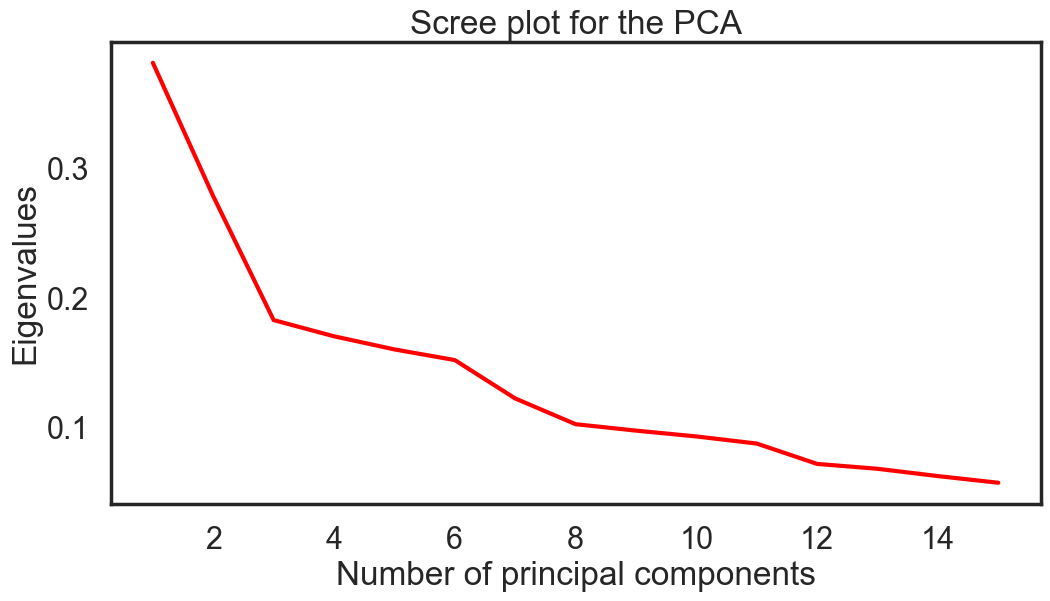

In [56]:
n_components = 15
pca = PCA(n_components=n_components)

tokeep = list(num_busi_cat['category'].values) + ['business_id']
business_df_sub = business_df[tokeep]
X = business_df_sub.drop(axis=1, inplace=False, labels=['business_id'])
X_pca = pca.fit_transform(X)

# # we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_

# # and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

In [57]:
v = var_exp[-1]
print("% variance explained by keeping 30 PCs:", v)

% variance explained by keeping 30 PCs: 83.2665606134196


In [50]:
def plot_pca_results(pc1, pc2, feature_name):
    temp = pd.DataFrame([])
    temp['pc1'] = X_pca[:,pc1]
    temp['pc2'] = X_pca[:,pc2]
    temp['f'] = business_df_sub[feature_name]
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(temp[temp['f'] == False]['pc1'], temp[temp['f'] == False]['pc2'], 'o', label='no', alpha=0.5, color="green")
    ax.plot(temp[temp['f'] == True]['pc1'], temp[temp['f'] == True]['pc2'], 'o', label='yes', alpha=0.5, color='red')
    ax.set(title=feature_name)
    ax.set(xlabel='PC ' + str(pc1+1))
    ax.set(ylabel='PC ' + str(pc2+1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

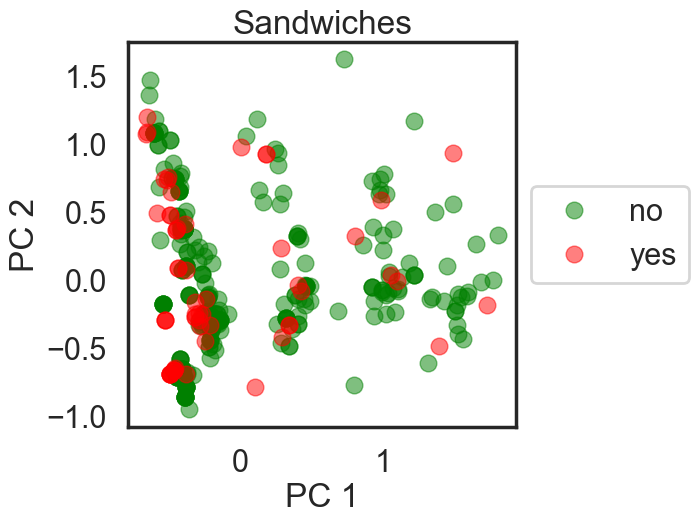

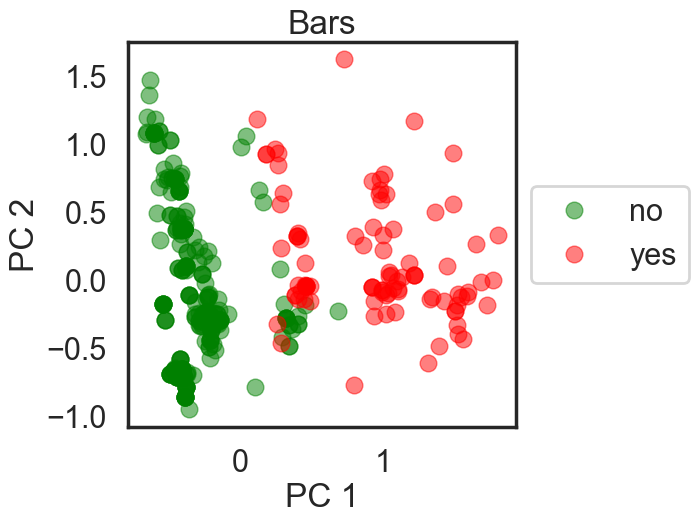

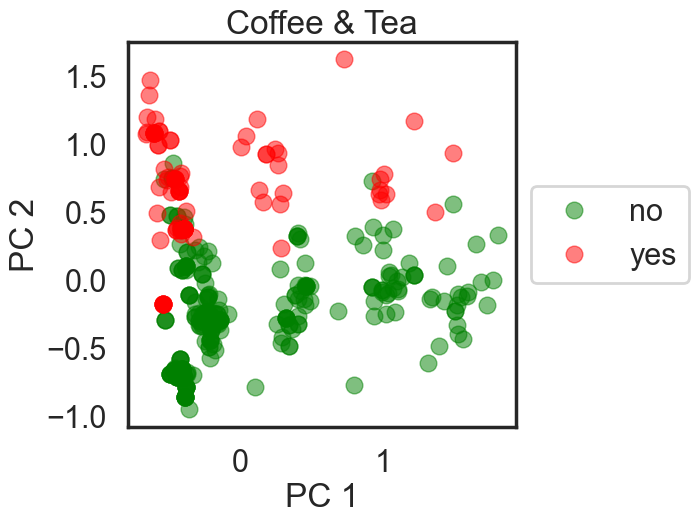

In [52]:
feature_name = 'Sandwiches'
plot_pca_results(0, 1, feature_name)
feature_name = 'Bars'
plot_pca_results(0, 1, feature_name)
feature_name = 'Coffee & Tea'
plot_pca_results(0, 1, feature_name)

In [69]:
### Reducing the number of restaurant attributes
# In addition to restaurant categories, there are restaurant attributes provided in the raw data. We expanded these into a Pandas dataframe and sought to filter down to those attributes that are more useful. We chose to filter out the attributes that are missing for most restaurants to reduce data sparsity. 

business_df = pd.read_pickle('restaurants.gzip')

In [70]:
# first figure out the business with the longest attribute list. 
# use this as the template for expanding the attributes into a pandas dataframe for all businesses.
business_df['attri_length'] = business_df['attributes'].apply(lambda x: len(x) if x else 0)

# for the business with the longest attribute list, get the primary keys in the json 
# to parse through the attribute list and expand them into a dataframe. 

temp = business_df[business_df['attri_length'] == business_df['attri_length'].max()].attributes.values[0]
temp = re.sub("'", '"', temp)
temp = re.sub(" T", " t", temp)
temp = re.sub(" F", " f", temp)
j = json.loads(temp)

# save the attribute names as a list so that I can use this as a template for parsing through all businesses. 
cols = list()
for keys in j:
    cols.append(keys)

TypeError: expected string or bytes-like object

In [64]:
business_attributes = pd.DataFrame(columns=cols)

for i in range(len(business_df)):
    
    temp = business_df['attributes'][i]
    temp = re.sub("'", '"', temp)
    temp = re.sub(" T", " t", temp)
    temp = re.sub(" F", " f", temp)
    j = json.loads(temp)
    
    output = list()
    for c in cols:
        try: 
            output.append(j[c])
        except KeyError:
            output.append('unknown')      
            
    temp = pd.DataFrame(columns=cols)
    temp.loc[0] = output
    
    business_attributes = [business_attributes, temp]
    business_attributes = pd.concat(business_attributes)

In [130]:
business_attributes.reset_index(drop=True, inplace=True)

# Eliminate the attributes where the top level is 'unknown'. 
# This means that we don't have the information for the majority of restaurants. 
temp = business_attributes.drop(axis=1, inplace=False, labels=['BusinessParking', 'BestNights', 'Music', 'Ambience', 
                                                        'GoodForMeal', 'DietaryRestrictions']).describe()
meaningful_attributes = temp.loc['top'] != 'unknown'

NameError: name 'business_attributes' is not defined

### Exploring the relationship between different restaurant attributes/categories:
We explored the relationship between different attributes so that it would help us further narrow down the list of attributes we would keep for collaborative filtering. We found that higher the restaurant price range, more restaurants have dressy/formal attire attributes. Also higher the price range, more restaurants accept reservations. Given these relationships, we could eliminate reservation acceptance and attire features, and keep only the price range feature. In a similar manner, we found that the diversity of alcohol served and whether the restaurant is good for kids were negatively related (visualization not shown here), suggesting that only one of these features is needed due to their interaction. 


In [66]:
def makePercPivotTable(outercat, innercat, indexcat):
    
    temp = business_attributes.pivot_table(aggfunc='count', columns=[outercat, innercat])
    temp = temp.loc[indexcat]
    temp = temp.reset_index()
    temp.columns = [outercat, innercat, 'subcount']

    totalcount = business_attributes.pivot_table(aggfunc='count', columns=[outercat])
    totalcount = totalcount.loc[indexcat]
    totalcount = totalcount.reset_index()
    totalcount.columns = [outercat, 'totalcount']

    temp = pd.merge(left=temp, right=totalcount, how='left', on=[outercat])
    temp['perc'] = temp['subcount'] * 100. / temp['totalcount']
    
    return temp

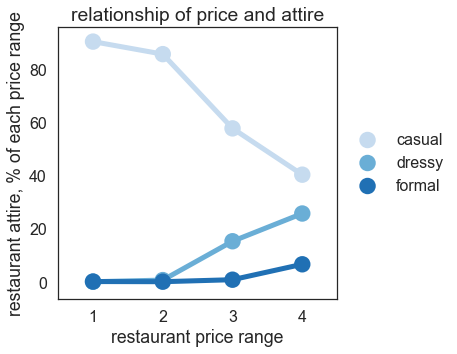

In [67]:
temp = makePercPivotTable('RestaurantsPriceRange2', 'RestaurantsAttire', 'OutdoorSeating')
temp = temp[temp['RestaurantsPriceRange2']!='unknown']
temp = temp[temp['RestaurantsAttire']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='RestaurantsPriceRange2', y='perc', hue='RestaurantsAttire',
              data=temp,
              palette='Blues', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='restaurant price range')
ax.set(ylabel='restaurant attire, % of each price range')
ax.set(title='relationship of price and attire')
plt.show()

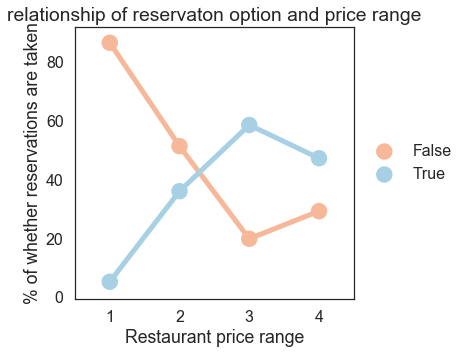

In [68]:
temp = makePercPivotTable('RestaurantsPriceRange2', 'RestaurantsReservations', 'OutdoorSeating')
temp = temp[temp['RestaurantsReservations']!='unknown']
temp = temp[temp['RestaurantsPriceRange2']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='RestaurantsPriceRange2', y='perc', hue='RestaurantsReservations', 
              data=temp, hue_order=[False, True],
              palette='RdBu' , ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Restaurant price range')
ax.set(ylabel='% of whether reservations are taken')
ax.set(title='relationship of reservaton option and price range')
plt.show()

On the other hand, the noise level of restaurants and whether it’s a good place for groups or it has a TV did not seem to have a strong positive or negative relationship. 

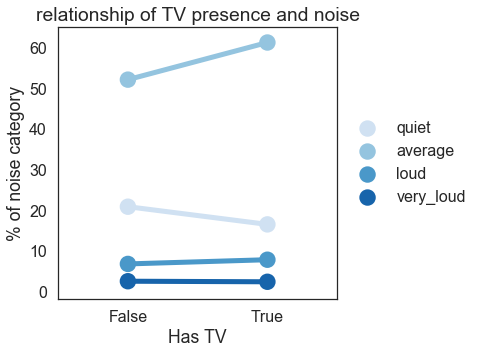

In [69]:
temp = makePercPivotTable('HasTV', 'NoiseLevel', 'OutdoorSeating')
temp = temp[temp['HasTV']!='unknown']
temp = temp[temp['NoiseLevel']!='unknown']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.pointplot(x='HasTV', y='perc', hue='NoiseLevel',
              data=temp, hue_order=['quiet', 'average', 'loud', 'very_loud'],
              palette='Blues', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Has TV')
ax.set(ylabel='% of noise category')
ax.set(title='relationship of TV presence and noise')
plt.show()

### Exploring the relationship between user attributes and the avg. star rating of a user
For this purpose, we created 3 new features from the original features in the dataset:
- User_friends_flag that indicates if the user has at least one friend
- User_elite_flag that indicates if the user has been an “elite user” at least one
- The year since when the user is at Yelp

The 2 first features seemed to have some relationship with the average number of stars of the user but the year does not seem to be a factor. Other features from the user dataset has been explored but they did not seem to have a significant relationship with the avg. star rating. 

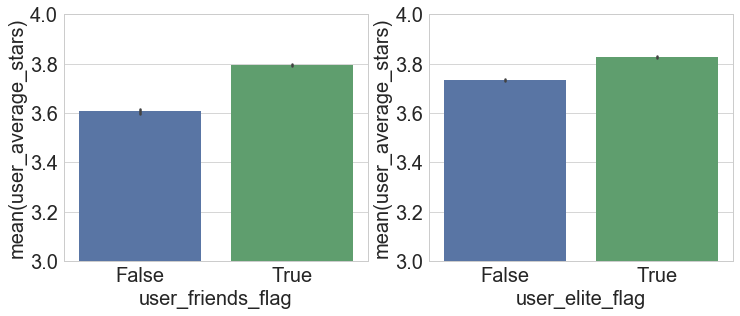

In [23]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
# f, ax = plt.subplots(1, 2, figsize=(10, 4))
g = sns.factorplot(x="user_friends_flag", y=y_user, data=users, kind='bar', ax=ax1);
ax1.set_ylim(3, 4);
plt.close(g.fig);
g = sns.factorplot(x="user_elite_flag", y=y_user, data=users, kind='bar', ax=ax2);
ax2.set_ylim(3, 4);
plt.close(g.fig);
plt.show();

<a id='review'></a>
[back to top](#top)

# Literature review / related work

## 1. Creating a baseline model
Before trying collaborative filtering which is based on user's experience with a particular restaurant, we first created a baseline model that captures the user's bias (e.g. some users are more likely to give higher ratings than others) and the bias of the restaurant (e.g. a restaurant could be a part of a national chain like Cheesecake Factory that has a higher brand power than Chipotle that recently suffered from mass infections). To this end, we relied on the method described in *Advances in Collaborative Filtering*, [(link)](https://datajobs.com/data-science-repo/Collaborative-Filtering-%5BKoren-and-Bell%5D.pdf) by Yehuda Koren's and Robert Bell.

## 2. Collaborative filtering
Collaborative filtering is based on the past experience of a user with different restaurants so that we can find what new restaurants that are similar to the ones user liked in the past for recommendation, and also to find the new restaurants that similars users have liked already. We found the following two websites very useful for understanding the concepts and methods for implementation (i.e. singular value decomposition and cosine similarity through pairwise distances). 
- [CF ref 1](https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html)
- [CF ref 2](https://towardsdatascience.com/how-to-build-a-simple-song-recommender-296fcbc8c85)






<a id='modeling'></a>
[back to top](#top)

# Modeling approach and project trajectory

## I. Baseline modeling

Using the method described in *Advances in Collaborative Filtering*, [(link)](https://datajobs.com/data-science-repo/Collaborative-Filtering-%5BKoren-and-Bell%5D.pdf) by Yehuda Koren's and Robert Bell, we created a baseline model with user bias and restaurant bias terms. According to Koren and Bell, the baseline model can be expressed as the following:
<h2><center>$b_{u i} = \mu + b_{u} + b_{ i}$</center></h2>
where $\mu$ represents the mean of all ratings. $b_{u}$ and $b_{i}$ represent the observed deviation of user $u$ and item $i$, respectively. In order to find the parameters $b_{u}$ and $b_{i}$, we used two approaches: 

#### Approach 1: Use the formulas given in the Koren and Bell paper to find the bias

<center>$b_{i}$ = $\left(\frac{\sum u \epsilon R(i) (r_{ui} - \mu)}{\lambda_{2} + |R(i)|}\right)$</center>
<center>$b_{u}$ = $\left(\frac{\sum u \epsilon R(i) (r_{ui} - \mu)}{\lambda_{3} + |R(u)|}\right)$</center>

Where $\lambda_{2}$ and $\lambda_{3}$ are the regularization parameters (to be chosen by cross-validation), R(i) represents all users who rated item $i$, and R(u) represents all items that user $u$ has rated.

#### Approach 2: Use Ridge regression to find the bias terms
We performed Ridge Regression using cross-validation.

## II. Memory-Based Collaborative filtering

As noted above in the Literature section, we wanted to take advantage of the wide user base and restaurant rating history in the Yelp database to provide a better recommendation system than the baseline model. To this aim, we implemented collaborative filtering (CF). The first step of CF is to create a user-item matrix, such as the one shown here for users and movies (image credit: CF ref 1).

![alt text](images/useritemmatrix.png "ui matrix")

Using this user-item matrix, we can calculate the similarities between two items, and also between two users. Between two items, we are looking to find how their ratings were similar. For user-user similarity, we look at all the items that were commonly rated by the two users and how much their ratings were similar. By doing so, we obtain similarity metrics for item-item and user-user, leading to item-item collaborative filtering and user-item collaborative filtering, respectively. These concepts are nicely illustrated in the following images (image credit: CF ref 2). 

Item-Item collaborative filtering will measure similarity by observing all users who have rated both restaurants.
![alt text](images/item-to-item.png "ui matrix")

User-Item collaborative filtering will measure similarity by observing all items that are rated by both users.
![alt text](images/user-to-item.png "ui matrix")

To calculate the similarity, we used cosine similarity. We consider the ratings as vectors in *n*-dimensional space, and calculate the angle between these vectors to determine the similarity. Cosine similarity for users *a* and *m* are calculated using the following formula:
<center>$$s_{u}^{cos}(u_{k},u_{a}) = \frac{u_{k} \cdot u_{a}}{\left\| u_{k} \right\|\left\| u_{a} \right\|} = \frac{\sum x_{k,m}x_{a,m}}{\sqrt{\sum x_{k,m}^{2}\sum x_{a,m}^{2}}}$$</center>
To calculate similarity between items m and b we used this formula:
<center>$$s_{u}^{cos}(i_{m},i_{b}) = \frac{i_{m} \cdot i_{b}}{\left\| i_{m} \right\|\left\| i_{b} \right\|} = \frac{\sum x_{a,m}x_{a,b}}{\sqrt{\sum x_{a,m}^{2}\sum x_{a,b}^{2}}}$$</center>

Because the Yelp ratings are in the scale of 1-5 (all positive numbers), the output of cosine distance will range between 0 and 1, where a value closer to 1 means a higher similarity. 


## III. Model-Based Collaborative filtering

Because there is not a huge overlap between all users and all restaurants, we observed that our dataframe is very sparce (>99.9%), as expected. Given this sparsity, we also implemented model-based CF that is able to deal with sparsity better than memory-based CF. Other drawbacks to memory-based CF include 1) lack of scalability and 2) cold-start problem. Cold-start problem means that it is not possible to make predictions for new users or restaurants that has no previous rating at all. Model-based collaborative filtering can handle higher sparsity levels and is more scalable, but also suffer from the cold-start problem. 

The way the model-based collaborative filtering handles high sparsity is through dimensionality reduction and latent variable decomposition. Although we only have the users' ratings for businesses as the dataset, underlying this data are the hidden preferences of users for certain businesses because of their hidden attributes. These latent variables are learned by the model-based CF. To do this, we used matrix factorization, which provides the latent vectors and allows filling in the sparse, original matrix: it predicts unknown ratings by taking the dot product of the latent features of users or items. For implementing matrix factorization, we used singular value decomposition (SVD). SVD is solved as follows:

$$X = U * S * V^{(T)} $$

Where: 
- **X** represents an **m** x **n** matrix
- **U** represents the **m** x **r** orthogonal matrix
- **S** represents the **r** x **r** diagonal matrix with non-negative real numbers on the diagonal
- **$V^{(T)}$** represents the **r** x **n** orthogonal matrix
- Elements on the diagonal of **S** are known as *singular values* of **X**

Matrix **X** can be factorized into **U**, **S**, and **V**.

- **U** represents the feature vectors corresponding to *users* in the hidden feature space
- **V** represents the feature vectors corresponding to *items* in the hidden feature space

Finally, we make our prediction by taking the dot product of **U**, **S**, and **$V^{(T)}$**.


## IV. Model evaluation
To maintain compatibility with results published by others implementation of recommendation systems, we are going to adopt the standard set by the Netflix prize and the quality of our results will be measured using the root mean squared error (MSE). 

$${\mathit{R}\mathit{M}\mathit{S}\mathit{E}} = \sqrt{\frac{1}{N}\sum(x_{i} - \hat{x_{i}})^{2}}$$

That measure puts more emphasis on large errors compared with the alternative of mean absolute error. 

## V. Decisions from the modeling
We found that the model-based CF had the lowest RMSE on the test set, thus we decided to pursue this approach for the recommendation system. We observed that for this model, the RMSE of validation data does not change too much for different values of k (i.e. at all values of k we tested, the RMSE is lower than other models by a factor of 10 or more). Thus, we decided to go with a large k (i.e. 100) so that we can make a greater number of predictions. 

<a id='baseline'></a>
[back to top](#top)

# The baseline model

### Approach 1: Obtain user and restaurant bias by using formulas given by Koren and Bell. 

For this approach, we created the next two functions. Using these functions, we looped through possible user bias and restaurant bias values, and used cross-validation to determine which combination is optimal.

In [71]:
def get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2):
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(bus_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(bus_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda2),
                       columns=['business_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=bus_id)
    return df

In [72]:
def get_user_offsets(df, rating, user_id, user_avg, lambda3):
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(user_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(user_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda3),
                       columns=['user_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=user_id)
    df['avg_review_stars'] = overall_avg
    return df

In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from itertools import product
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time
import sys

In [74]:
df = pd.read_pickle('recommendations.gzip')
sample_df = pd.read_pickle('sample.gzip')

In [75]:
"""
add_numerical_id()
-this function replaces string identifiers with numeric identifiers


inputs: dataframe, variable to be replaced, name of new variable
outputs: dataframe with new variables
"""
def add_numerical_id(df, var, new_var):
    # Get the list of Later, we'll change the user_id and business_id by numerical values
    unique_values = df[var].unique()
    n_unique_values = len(unique_values)
    df_var_id = pd.DataFrame(data=unique_values, index=range(0,n_unique_values), columns=[var])
    df_var_id.index.name = new_var
    df_var_id.reset_index(drop=False, inplace=True)
    df = df.merge(df_var_id, how='left', on=var)
    return df

In [76]:
"""
create_dummy_var()
--this function creates dummy variables and appends them to the dataframe


inputs: dataframe, list of variables to create dummy variables
outputs: updated dataframe, list of dummy variables that were created

"""
def create_dummy_var(df, list_vars):
    list_dummy_var = []
    for var in list_vars:
        dummy_vars = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = df.merge(dummy_vars, how='left', left_index=True, right_index=True)  
        list_dummy_var.extend(dummy_vars.columns.values)
    return df, list_dummy_var

In [77]:
cat_ftres = ['is_open', 'state', 'Fast Food', 'Sandwiches', 'Coffee & Tea',
             'Burgers', 'user_useful', 'user_fans']

df, ftres_dummy = create_dummy_var(df, cat_ftres)
sample_df, sample_ftres_dummy = create_dummy_var(sample_df, cat_ftres)

df = add_numerical_id(df, 'user_id', 'user_id_key')
df = add_numerical_id(df, 'business_id', 'business_id_key')

sample_df = add_numerical_id(sample_df, 'user_id', 'user_id_key')
sample_df = add_numerical_id(sample_df, 'business_id', 'business_id_key')

### Approach 2: Use Ridge regression for optimizing the bias terms

In [78]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5, scoring=None):
    if not scoring:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=scoring)
    gs.fit(Xtrain, ytrain)
    return gs

def cv_optimize_with_sets(clf, parameters, sets, model_name, param_name, n_folds=5, scoring=None):
    Xtrain, Xtest = sets['X_train_sparse'], sets['X_test_sparse']
    ytrain, ytest = sets['y_train'], sets['y_test']
    gs = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, scoring=scoring)
    limit_values = np.vectorize(boundaries_stars)
    ytrain_hat = limit_values(gs.predict(Xtrain))
    ytest_hat = limit_values(gs.predict(Xtest))
    # R2
    train_r2 = r2_score(ytrain, ytrain_hat)
    test_r2 = r2_score(ytest, ytest_hat)
    # RMSE
    train_RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_hat))
    test_RMSE = np.sqrt(mean_squared_error(ytest, ytest_hat))
    print("""{}. Best parameter: {}={}. 
                 Train R2:{:2.2f}% Test R2:{:2.2f}% 
                 Train RMSE: {:0.3f}. Test RSME: {:0.3f}""".format(
                 model_name, param_name, gs.best_params_[param_name],
                 train_r2, test_r2, train_RMSE, test_RMSE))
    return gs, gs.best_params_[param_name], train_r2, test_r2, train_RMSE, test_RMSE

In [79]:
def add_bias(df, var, var_name, quant_var):
    overall_avg = df[quant_var].mean()
    df_bias = df.groupby(var, as_index=False).mean()[[var, quant_var]]
    var_mean = str(var_name+'_mean')
    var_bias = str(var_name+'_bias')
    df_bias.rename(columns={quant_var:var_mean}, inplace=True) 
    df_f = df.merge(df_bias, how='left', on=var)
    df_f[var_bias] = df_f[var_mean] - overall_avg
    df['avg_review_stars'] = overall_avg
    return df_f

In [80]:
def cv_optimize_with_sets(clf, parameters, sets, model_name, param_name, n_folds=5, scoring=None):
    Xtrain, Xtest = sets['X_train_sparse'], sets['X_test_sparse']
    ytrain, ytest = sets['y_train'], sets['y_test']
    gs = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, scoring=scoring)
    limit_values = np.vectorize(boundaries_stars)
    ytrain_hat = limit_values(gs.predict(Xtrain))
    ytest_hat = limit_values(gs.predict(Xtest))
    # R2
    train_r2 = r2_score(ytrain, ytrain_hat)
    test_r2 = r2_score(ytest, ytest_hat)
    # RMSE
    train_RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_hat))
    test_RMSE = np.sqrt(mean_squared_error(ytest, ytest_hat))
    print("""{}. Best parameter: {}={}.                   
                 Train RMSE: {:0.3f}. Test RSME: {:0.3f}""".format(
                 model_name, param_name, gs.best_params_[param_name],
                  train_RMSE, test_RMSE))
    return gs, gs.best_params_[param_name], train_r2, test_r2, train_RMSE, test_RMSE

In [92]:
"""
create_set()
-this variable transforms the training and test set into a matrix 
suitable for this regression

inputs: training dataset, test dataset, response variables, predictor features,
        index of category features

outputs: altered dataframe suitable for this regression

"""
def create_set(df_train, df_test, response, ftres, cat_ftres_index):
    dataset = {}
    dataset['response']      = response
    dataset['ftres']         = ftres
    
    # Response variable
    dataset['y_train'] = np.ravel(df_train[dataset['response']])
    dataset['y_test']  = np.ravel(df_test[dataset['response']])
    
    assert (type(ftres) == str or type(ftres) == list)
    if type(ftres) == list:
        dataset['X_train'] = df_train[dataset['ftres']].values
        dataset['X_test']  = df_test[dataset['ftres']].values        
    else:
        dataset['X_train'] = df_train[dataset['ftres']].values.reshape(-1,1)
        dataset['X_test']  = df_test[dataset['ftres']].values.reshape(-1,1)
    
    # All values must be float
    dataset['X_train'] = dataset['X_train'].astype(float)
    dataset['X_test'] = dataset['X_test'].astype(float)
    X_all = np.concatenate([dataset['X_train'], dataset['X_test']], axis=0)
    
    # Encode categorical variables in a sparse matrix
    #print(cat_ftres_index)
    encoder = OneHotEncoder(sparse=True)
    encoder.fit(X_all)
    dataset['X_train_sparse'] = encoder.transform(dataset['X_train'])
    dataset['X_test_sparse'] = encoder.transform(dataset['X_test'])    
    return dataset

In [89]:
cat_ftres_index

NameError: name 'cat_ftres_index' is not defined

In [82]:
def boundaries_stars(x):
    return min(max(x, 1), 5)

In [83]:
"""
train_and_predict_model()
-this function takes a model, dataframe, and predictor/response information.
 it then fits the model and reports various scores of interest
 
inputs: regression model, dataframe/predictor/response information that is stored in a **set** variable
outputs: dictionary of relevant scores
"""
def train_and_predict_model(model, input_set):
    
    start = time.time()
    # Dictionary to save all the results
    m = dict()
    
    #initialize x and y for regression
    m['X_train'] = input_set['X_train']
    m['y_train'] = input_set['y_train']
    
    m['X_test'] = input_set['X_test']
    m['y_test'] = input_set['y_test']
    
    # Fit the model with sparse matrix
    model.fit(input_set['X_train_sparse'], m['y_train'])
    
    # Predict the values with the model in the training and test set 
    # restricting the values to the range (1,5)
    limit_values = np.vectorize(boundaries_stars)
    m['y_hat_train'] = limit_values(model.predict(input_set['X_train_sparse']))
    m['y_hat_test']  = limit_values(model.predict(input_set['X_test_sparse']))
    
    # Parameter of goodness of fit: MSE
    m['train_RMSE'] = np.sqrt(mean_squared_error(m['y_train'], m['y_hat_train']))
    m['test_RMSE'] = np.sqrt(mean_squared_error(m['y_test'], m['y_hat_test']))
    
    # Parameter of goodness of fit: R2
    m['train_r2'] = r2_score(m['y_train'], m['y_hat_train'])
    m['test_r2'] = r2_score(m['y_test'], m['y_hat_test'])
    
    size = 0
    for key in m: size+=sys.getsizeof(m[key])
    m['size'] = size
    m['runtime'] = time.time() - start
    return m

In [84]:
"""
cross_validate_lambda()
-this function uses the method described in Step2-Option1 to return statistical information
-for every lambda combination specified.

inputs: dataframe, predictor features, response variable, rating variable name,
        business_id column, business_average column,
        user_id column, user_average column,
        parameter dictionary specificying which lambda values to loop through,
        amount of folds to perform in cross-validation
        
outputs: dictionary storing the mean results from N-Fold cross validation in the following areas:
         -train_r2
         -train_RMSE
         -test_r2
         -test_RMSE

"""

def cross_validate_lambda(df, ftres_all, response, rating, bus_id, bus_avg, user_id, user_avg,
                          param_dict, nfolds):
    
    scoreDict={}
    for lambda2, lambda3 in product(*param_dict.values()):
        join1 = get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2)
        join2 = get_user_offsets(join1, rating, user_id, user_avg, lambda3)
        
        sets = {}

        
        train_r2 = []
        test_r2 = []
        train_RMSE = []
        test_RMSE = []
        for f_train, f_val in KFold(n_splits=nfolds, shuffle=True, random_state=9001).split(join2.index):
            train_split = join2.iloc[f_train]
            val_split = join2.iloc[f_val]
            
            sets['bsln'] = create_set(train_split, val_split, 'review_stars', ftres_all, [5,6])
            
            allScores = train_and_predict_model(LinearRegression(), sets['bsln'])
            
            train_r2.append(allScores['train_r2'])
            train_RMSE.append(allScores['train_RMSE'])
            
            test_r2.append(allScores['test_r2'])
            test_RMSE.append(allScores['test_RMSE'])
        scoreDict[lambda2, lambda3] = {'train_r2':np.mean(train_r2),
                                       'train_RMSE':np.mean(train_RMSE),
                                       'test_r2':np.mean(test_r2),
                                       'test_RMSE':np.mean(test_RMSE)}
        

    return scoreDict

def create_optimal_model(df, ftres_all, response, rating, bus_id, bus_avg, user_id, user_avg,
                          lambda2,lambda3):
    join1 = get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2)
    join2 = get_user_offsets(join1, rating, user_id, user_avg, lambda3)

    train_split, test_split = train_test_split(join2, test_size=0.25, random_state=777)

    sets['bsln'] = create_set(train_split, test_split, 'review_stars', ftres_all, [5,6])
    results = train_and_predict_model(LinearRegression(), sets['bsln'])
    return results

In [94]:
param_dict = OrderedDict(lambda2 = [i*12 for i in range(1,3)],
                        lambda3=[i*12 for i in range(1,4)])

sample_ftres_all = sample_ftres_dummy + ['review_stars', 'user_id_key', 'business_id_key', 'user_bias', 'business_bias', 'avg_review_stars']

In [95]:
Step2_Option1_CV_Results = cross_validate_lambda(df=sample_df, ftres_all=sample_ftres_all, response=['review_stars'], 
                                     rating='review_stars', bus_id='business_id', bus_avg='stars', 
                                     user_id='user_id', user_avg='user_average_stars', param_dict=param_dict, nfolds=5)

/Users/yellow_flash/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/yellow_flash/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/yellow_flash/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/yellow_flash/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

KeyboardInterrupt: 

### Baseline model: Comparison of approaches 1 & 2

#### Approach 1 results:
(lambda2,lambda3) values of (30,45) return the lowest test RMSE, so we will use those values on a 75/25 train/test split to determine accuracy on the sample set.

In [19]:
Step2_Option1_Results_DF = pd.DataFrame(Step2_Option1_CV_Results)
print(Step2_Option1_Results_DF.loc['test_RMSE',:].idxmin())

(30, 45)


In [23]:
sets={}
sample_train, sample_test = train_test_split(sample_df[sample_ftres_dummy + ['review_stars']], test_size=0.25, random_state=777)
sets['bsln'] = create_set(sample_train, sample_test, 'review_stars', sample_ftres_dummy, [5,6])

Step2_Option1_Final_Results = create_optimal_model(df=sample_df, ftres_all=sample_ftres_dummy, response=['review_stars'], 
                                     rating='review_stars', bus_id='business_id', bus_avg='stars', 
                                     user_id='user_id', user_avg='user_average_stars',lambda2=30,lambda3=45)

Step2_Option1_Final_Results['test_RMSE']

1.1872544600959554

#### Approach 2 results:

In [15]:
sample_ftres_all = sample_ftres_dummy + ['review_stars', 'user_id_key', 'business_id_key', 'business_mean',
                           'user_mean', 'user_bias', 'business_bias', 'avg_review_stars']

Step2_Option2_DF = add_bias(sample_df, 'business_id', 'business', 'review_stars')
Step2_Option2_DF = add_bias(Step2_Option2_DF, 'user_id', 'user', 'review_stars')

#Step2_Option2_DF.drop(['business_id','user_id','review_stars'],axis=1,inplace=True)        
sample_ftres_all.remove('review_stars') #removing this since it is the response variable, and needs to be separated for our next function

sample_train, sample_test = train_test_split(Step2_Option2_DF[sample_ftres_all + ['review_stars']], test_size=0.25, random_state=777)
sets={}
sets['bsln'] = create_set(sample_train, sample_test, 'review_stars', sample_ftres_all, [5,6])

TypeError: agg function failed [how->mean,dtype->object]

In [23]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 1e2,1e3, 1e4, 1e5]
ridge = Ridge(fit_intercept=False)
gs, blsn2_alpha,train_r2, test_r2,train_RMSE, test_RMSE = cv_optimize_with_sets(ridge, {"alpha": alphas},
                                                        sets['bsln'], "Ridge Linear Regr Model",
                                                        "alpha", n_folds=5, 
                                                        scoring="neg_mean_squared_error")

Ridge Linear Regr Model. Best parameter: alpha=100000.0.                   
                 Train RMSE: 1.860. Test RSME: 1.850


##### We see that our first method of regularization (regularizing by introducing a lambda term in the demoniator) gives us a better RMSE score than using the Ridge method of regularization.

In [96]:
### Pre-collaborative filtering step: Organize data into a table with users and businesses' ratings as two columns.

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold, cross_validate, train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [97]:
"""
add_numerical_id()
-this function replaces string identifiers with numeric identifiers


inputs: dataframe, variable to be replaced, name of new variable
outputs: dataframe with new variables
"""
def add_numerical_id(df, var, new_var):
    # Get the list of Later, we'll change the user_id and business_id by numerical values
    unique_values = df[var].unique()
    n_unique_values = len(unique_values)
    df_var_id = pd.DataFrame(data=unique_values, index=range(0,n_unique_values), columns=[var])
    df_var_id.index.name = new_var
    df_var_id.reset_index(drop=False, inplace=True)
    df = df.merge(df_var_id, how='left', on=var)
    return df

In [99]:
df = pd.read_pickle('recommendations.gzip')
sample_df = pd.read_pickle('sample.gzip') 
#sample.csv is ~10% of the recommendations dataframe

n_users = df['user_id'].unique().shape[0]
n_items = df['business_id'].unique().shape[0]

sample_n_users = sample_df['user_id'].unique().shape[0]
sample_n_items = sample_df['business_id'].unique().shape[0]
print(n_users, n_items)
print(sample_n_users, sample_n_items)

df = add_numerical_id(df, 'user_id', 'user_id_key')
df = add_numerical_id(df, 'business_id', 'business_id_key')

sample_df = add_numerical_id(sample_df, 'user_id', 'user_id_key')
sample_df = add_numerical_id(sample_df, 'business_id', 'business_id_key')

df.drop(['user_id','business_id'],axis=1,inplace=True)
sample_df.drop(['user_id','business_id'],axis=1,inplace=True)

#create a unique list of user_id_keys and their corresponding average rating
#user_id_key_rating = df.groupby('user_id_key')['user_average_stars'].max()
#user_rating_count = df.groupby('user_id_key')['user_average_stars'].count()

user_highest_index = df.groupby('user_id_key',sort=False)['review_stars'].idxmax()
business_by_index = df.loc[user_highest_index,'business_id_key']

user_highest_rated_restaurant = pd.Series(data=business_by_index.values,
          index=user_highest_index.index)

#create a unique list of business_id_keys and their corresponding business name
business_id_key_name = df.groupby('business_id_key')['name'].max()

#other features to be included in the model:
ftres_response = ['review_stars']
ftres_ids = ['user_id_key', 'business_id_key']
ftres_all = ftres_ids + ftres_response

8939 380
8939 380


In [100]:
df2 = pd.read_pickle('recommendations.gzip')

In [101]:
df2['business_id'].unique().shape

(380,)

In [102]:
df = df[ftres_all]
sample_df = sample_df[ftres_all]

<a id='memory'></a>
[back to top](#top)

# Memory-Based Collaborative Filtering

In [103]:
# Prior to applying memory-based collaborative filtering, we first organized the data into a dataframe
# where each row is a pair of user and restaurant review rating. 
df.head()

,user_id_key,business_id_key,review_stars
0,0,0,5
1,1,1,1
2,2,2,1
3,3,3,1
4,4,4,5


Using the above dataframe, we created user-item matrix for performing memory-based collaborative filtering. In the user-item matrix, one axis represents the users, and another axis being the restaurants. Each value in the matrix will represent the rating for that user and restaurant. 

In [104]:
"""
create_matrix()

-transforms a dataframe into a user-item matrix

inputs: dataframe, number of users, number of items
outputs: user-item matrix

"""
def create_matrix(df, n_users, n_items):
    matrix = np.zeros((n_users,n_items))
    
    for line in df.itertuples():     
        
        matrix[line[1]-1, line[2]-1] = line[3]
    
    return matrix

The dimensions of the matrices are (n_users * n_items). This causes the matrix to be quite large. Because the large size of the data is computationally too costly, we decided to use a random sample of the entire data set. 

In [105]:
train, test = train_test_split(df, test_size=0.25) #split dataframe into train/test
sample_train, sample_test = train_test_split(sample_df, test_size=0.25)


train_matrix = create_matrix(train, n_users, n_items)
test_matrix = create_matrix(test, n_users, n_items)

sample_train_matrix = create_matrix(sample_train, sample_n_users, sample_n_items)
sample_test_matrix = create_matrix(sample_test, sample_n_users, sample_n_items)

print(train_matrix.shape)
print(sample_train_matrix.shape)

(8939, 380)
(8939, 380)


In [106]:
sample_train.shape

(22947, 3)

Using the user-item matrix (sample data, not the entire set), we computed the item-item similarity and user-item similarity. Since the ratings are all positive, the output will range from 0 to 1.

1. Item-Item collaborative filtering: "Users who liked this restaurant also liked ..."
2. User-Item collaborative filtering: "Users who are similar to you also liked ..."

In [107]:
sample_user_similarity = pairwise_distances(sample_train_matrix, metric='cosine')
sample_item_similarity = pairwise_distances(sample_train_matrix.T, metric='cosine')

Next is to use our similarity matrices to make predictions. We will need to consider bias again when comparing user-similarity.  This is not necessary for item-similarity, because each user is used in the prediction itself. Also, we created a training matrix with 75% of the observations, and a test matrix with 25% of the observations.

In [108]:
"""
memory_based_prediction()

-uses the cosine similarity to make predictions for user-item ratings

inputs: ratings matrix, cosine similarity, flag to account for biases
outputs: predictions for user-item ratings

"""

def memory_based_prediction(ratings, similarity, bias=False):
    if bias: #account for biases for users
        mean_user_rating = ratings.mean(axis=1)
        bias = (ratings-mean_user_rating[:,np.newaxis])
        prediction = mean_user_rating[:,np.newaxis] + similarity.dot(bias) / np.array([np.abs(similarity).sum(axis=1)]).T
    else:
        prediction = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        
    return prediction

In [109]:
sample_item_prediction = memory_based_prediction(sample_train_matrix, sample_item_similarity)
sample_user_prediction = memory_based_prediction(sample_train_matrix, sample_user_similarity, bias=True)

In [110]:
"""
rmse()
-computes the root mean squared error for a models' predictions

inputs: rating prediction, actual rating
outputs: random mean squared error

"""

def rmse(y, y_hat):
    y_hat = y_hat[y.nonzero()].flatten() #only consider predicted ratings that are in the dataset
    y = y[y.nonzero()].flatten()
    rmse = sqrt(mean_squared_error(y_hat, y))
    return rmse

We see that the user-based prediction model is slightly more accurate than the item-based prediction model.

In [111]:
print("user-item based collaborative filtering RMSE: ", rmse(sample_test_matrix,sample_user_prediction)) 
print("item-item based collaborative filtering RMSE: ", rmse(sample_test_matrix,sample_item_prediction)) 

user-item based collaborative filtering RMSE:  4.063388109187458
item-item based collaborative filtering RMSE:  4.110230800220477


<a id='modelcf'></a>
[back to top](#top)

# Model-based Collaborative Filtering

Because there is not a huge overlap between all users and all restaurants, we observed that our dataframe is very sparce (>99.9%), as expected. Given this sparsity, we also implemented model-based CF that is able to deal with sparsity better than memory-based CF. 

In [112]:
sparsity=round(1.0-len(df)/float(n_users*n_items),10)
print("percent sparsity = ", sparsity) 

percent sparsity =  0.990992752


In [113]:
"""
SVD_prediction()
-uses singular value decomposition to make rating predictions

inputs: matrix, number of singular values and vectors to compute
output: prediction through SVD

"""

def SVD_prediction(matrix, k_size):
    u, s, vt = svds(matrix, k = k_size) #create matrices described above
    s_diag_matrix=np.diag(s) #take diagonal matrix of S
    prediction = np.dot(np.dot(u, s_diag_matrix),vt) #prediction is the dot product of u, s, and vt
    
    return prediction

Since it is not known how many latent (singular) vectors we should use for the model, we decided to use cross validation to choose the optimal K. 

In [114]:
"""
cross_validate_k
-uses cross validation to determine the optimal K size for the SVD_prediction() function

inputs: dataframe, list of k sizes to use, amount of folds to use in cross-validation
outputs: dictionary of train RMSE values and test RMSE values for each size of k
"""

def cross_validate_k(df, k_list, nfolds):
    scoreDict = {}
    for k_size in k_list:
        train_RMSE_list = []
        val_RMSE_list = []
        for f_train, f_val in KFold(n_splits=nfolds,shuffle=True,random_state=9001).split(df.index):
            train_matrix = create_matrix(df.iloc[f_train], n_users, n_items)
            val_matrix = create_matrix(df.iloc[f_val], n_users, n_items)
            
            X_pred = SVD_prediction(train_matrix, k_size)
            train_RMSE = rmse(X_pred, train_matrix)
            val_RMSE = rmse(X_pred, val_matrix)
            
            train_RMSE_list.append(train_RMSE)
            val_RMSE_list.append(val_RMSE)
        
        scoreDict[k_size] = [np.mean(train_RMSE_list),np.mean(val_RMSE_list)]
    return scoreDict

We will use our sample dataset to cross-validate K, since the process is very computationally expensive. 

In [115]:
k_list = [1,5,10,20,50,100]
svd_score_dict = cross_validate_k(df=sample_train, 
                                  k_list=k_list,
                                  nfolds=5)

In [123]:
np.array(list(svd_score_dict.values()))[:, 0]

array([0.31296156, 0.29853973, 0.28529509, 0.26377765, 0.21536118,
       0.15915791])

In [124]:
svd_df = {'k': [], 'Train': [], 'Validatiom': []}
svd_df['k'] = k_list
svd_df['Train'] = list(np.array(list(svd_score_dict.values()))[:, 0])
svd_df['Validation'] = list(np.array(list(svd_score_dict.values()))[:, 1])



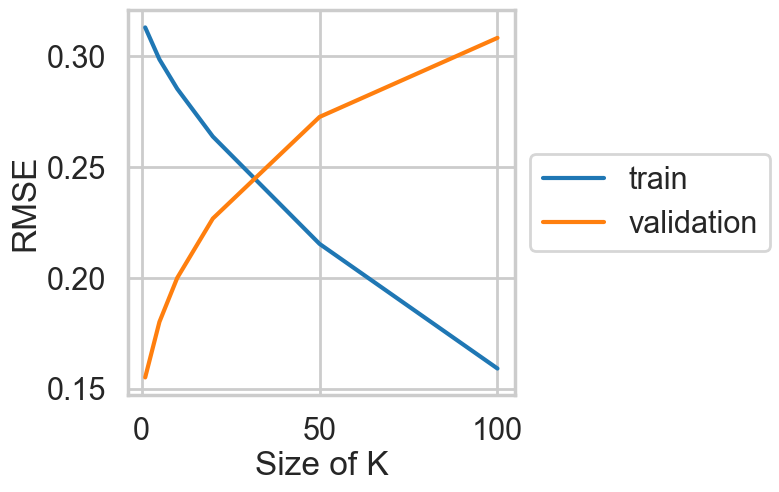

In [126]:
sns.set_context('poster')
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1 ,figsize=(5,5))
ax.plot(svd_df['k'], svd_df['Train'], label='train')
ax.plot(svd_df['k'], svd_df['Validation'], label='validation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Size of K')
ax.set_ylabel('RMSE')
plt.show()

We see that as k increases, the training RMSE decreases while the validation RMSE increases. This might look like the model is getting overfitted as k is increasing. However, the actual reason is that the model is able to make a greater number of predictions with a larger k, thus the overall error is larger. Furthermore, the difference in RMSE is only about 0.01, so even at the "worst" RMSE at k=30, the model-based CF is performing much better than the memory-based CF and the baseline model. 

In [127]:
# to illustrate that the number of predictions is increasing with a greater k:
sizeDict = {}
for k in k_list:
    sizeDict[k] = (SVD_prediction(sample_train_matrix, k).flatten() >=1).sum()

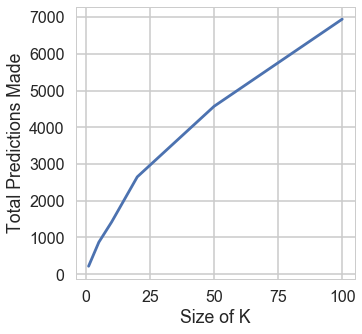

In [26]:
fig, ax = plt.subplots(1, 1 ,figsize=(5,5))
ax.plot(size_df['k'], size_df['Total Count of Predictions'])
ax.set_xlabel('Size of K')
ax.set_ylabel('Total Predictions Made')
plt.show()

##### RMSE of model-based CF:
Unfortunately the full prediction matrix is too large to report the RMSE score. As a result, we report the sample RMSE score as a reference. We would expect the overall RMSE to be somewhat similar.

In [128]:
X_pred = SVD_prediction(train_matrix, 100)
sample_X_pred = SVD_prediction(sample_train_matrix, 100)
print(rmse(sample_X_pred, sample_test_matrix))

0.3444911185602257


<a id='results'></a>
[back to top](#top)

# Results
Even though we can't report the RMSE score, we can still use the results from this prediction matrix to make recommendations. However, this SVD method is still unable to make predictions for certain users, as we will demonstrate below. But first, we filtered the data so that we won't recommend restaurants that a user has already been to. 

In [28]:
# filter the data to get rid of restaurants that a user has been to already
entire_matrix = create_matrix(df, n_users, n_items)

We also only want to recommend restaurants that we predict the user will like. The challenge with this is for users that do not have many ratings. If a user only has 2 ratings, for example, that is not enough information to determine what types of restaurants that user likes. 

As a result, we will use any predictions from the SVD model if the user has less than 10 total ratings. If the user has more than 10 total ratings, we will only make recommendations from the SVD model if we predict that the given restaurant will be rated higher than that user's average.

If we are unable to make at least 3 recommendations using these methods, we will add additional recommendations by looking at that user's highest rated restaurant, then using k-nearest neighbors with cosine similarity to find the most similar restaurants.

First, we determined how many users will be given recommendations based on the model-based CF prediction. 

In [29]:
def user_prediction_count(model,n_users):
    prediction_count=0
    user=0
    while user <= n_users:
        #figure out which users the restaurant has already rated
        restaurants_rated = entire_matrix[user,:].nonzero()
        
        if user_rating_count[user] <= 10:#if the user has less than 10 ratings, we will use any predictions from the SVD model
            mask = X_pred[user,:] >= 1.0 #a predicted rating of less than 1.0 means we have an invalid prediction
        else:#if the user has 10 ratings, we will only recommend restaurants that have a predicted rating higher than the user's average
            mask = X_pred[user,:] >= user_id_key_rating[user]
        restaurant_predictions = np.where(mask)
        
         #remove already-rated restaurants from possible restaurant recommendations
        recommendations = np.setdiff1d(restaurant_predictions,restaurants_rated)
        #return recommendations.shape[0]

        if recommendations.shape[0] >=1:
           
            prediction_count+=1
        user+=1
    return prediction_count

In [30]:
user_prediction_count(X_pred,10000)

919


Out of 10,000 users, our model is able to make SVD recommendations for ~10%. As a result, we expect 90% of recommendations to come from k-nn using cosine similarity.

Recall that cosine similarity is not scalable. As a result, we will calculate k-nn using the sample dataset. However, since we are not using this k-nn to fit a model, we can combine our training and test set to increase the size of the matrix.

In [31]:
sample_entire_matrix = create_matrix(sample_df,sample_n_users, sample_n_items)
sample_entire_item_similarity = pairwise_distances(sample_entire_matrix.T, metric='cosine')

In [32]:
"""
similar_businesses()
-function essentially works as a k-NN function using the pairwise distance matrix

-this function filters out non-ratings by filtering out any cosine similarities of 1.0. The idea is that
 a similarity of 1.0 is highly unlikely unless it is as a result of pure non-ratings. The sophistication of this function would
 be an area of improvement if we had more time on this assignment
 
inputs: list of businesses, 

"""
def similar_businesses(businesses,similarity_matrix,k):
    closest = np.zeros((n_items,k))
    for business in businesses:
        all_businesses = similarity_matrix[business,:]
        mask = all_businesses < 1
        closest[business]=np.where(mask, all_businesses, np.nanmin(all_businesses)).argsort()[-k:][::-1]
    return closest    

In [33]:
business_similarity_matrix = similar_businesses(sample_df['business_id_key'].unique(),sample_entire_item_similarity,3)
business_similarity_matrix

array([[ 7323.,  4108.,   623.],
       [ 6635.,   998.,  7152.],
       [ 5696.,  2726.,  7248.],
       ..., 
       [    0.,     0.,     0.],
       [    0.,     0.,     0.],
       [    0.,     0.,     0.]])

Now we are ready to make our final function

In [34]:
def restaurant_recommender(user):
    #figure out which users the restaurant has already rated
    restaurants_rated = entire_matrix[user,:].nonzero()

    if user_rating_count[user] <= 10:#if the user has less than 10 ratings, we will use any predictions from the SVD model
        mask = X_pred[user,:] >= 1.0 #a predicted rating of less than 1.0 means we have an invalid prediction
    else:#if the user has 10 ratings, we will only recommend restaurants that have a predicted rating higher than the user's average
        mask = X_pred[user,:] >= user_id_key_rating[user]
    restaurant_predictions = np.where(mask)

     #remove already-rated restaurants from possible restaurant recommendations
    recommendations = np.setdiff1d(restaurant_predictions,restaurants_rated)
    
    n_SVD_recommendations = recommendations.shape[0]
    
    if n_SVD_recommendations >=3: #if we can give 3 recommendations from SVD, we will do that
        listOfIndices = list(recommendations)
        top3Indices = X_pred[user,recommendations].argsort()[-3:][::-1]
        final_recommendation = [listOfIndices[i] for i in top3Indices]
        #last, we convert the business_id_key to the business name
        return list(business_id_key_name[final_recommendation].values)
    
    elif n_SVD_recommendations >=1: #if we can't give 3 recommendations, but can give 1, that will be our first recommendation
        listOfIndices = list(recommendations)
        top_n_Indices = X_pred[user,recommendations].argsort()[-n_SVD_recommendations:][::-1]
        final_recommendation = [listOfIndices[i] for i in top_n_Indices]
    else: #if no SVD predictions, create an empty list to append to
        final_recommendation = []
    
    #find restaurants similar to that user's highest rated restaurant
    highest_rated_restaurant = user_highest_rated_restaurant[user]
    similar_to_highest_rated = list(business_similarity_matrix[highest_rated_restaurant].astype(int))
    
    #add these similar restaurants to the recommendation list until we have 3 total recommendations
    for i in range(3-n_SVD_recommendations):
        final_recommendation.append(similar_to_highest_rated[i])
    #last, we convert the business_id_key to the business name
    return list(business_id_key_name[final_recommendation].values)

In [38]:
# for user no. 6
restaurant_recommender(6)

['Bakie Bites Bakery', 'Popeyes Louisiana Kitchen', 'El Pollo Loco']


In [42]:
# for user no. 6000
restaurant_recommender(6000)

['Panera Bread', "Fib's Fine Italian Beef & Sausage", 'Red Brick Pizza']


In [43]:
# for user no. 60000
restaurant_recommender(60000)

["Harvey's Restaurants", '5 & Diner', 'Ong Gie']


<a id='conclusion'></a>
[back to top](#top)

# Conclusions and Future Work

Between all of the models tested, SVD had the best score when using the RMSE metric (baseline: 1.2; memory CF:  3.9; model-based CF (SVD): 0.04). The drawback to SVD is that it only makes predictions for ~10% of users, meaning that an ensemble method is required to make predictions using an SVD model. Another drawback to our SVD model is that it just makes a prediction; there are no coefficients, which makes interpretability of features difficult. 

If given more time, we would revisit the cosine similarity functions. It seems that these functions failed because there are such a large amount of users. If we were able to filter to a subset of the most important users for any given business, we would be able to reduce the size of this matrix and make a more accurate similarity model as a result. However, this approach would be limited to only those users who are active in Yelp. 

The results from our regularized regression could also likely be improved if we spent more time determining what the most important categorical features were. Lastly, another avenue for improvement would be to incorporate the regularized user bias and restaurant bias into our collaborative filtering models so that it increases the interpretability and the number of predictable users. Such hybrid approach would also address the cold-start problem. Our EDA work clearly showed that there are relationships between restaurant attributes, thus it would be a great addition to the CF models to improve predictability. 